<center>
<img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="300" height="150"/></left>
<h1><center><font size=8>Word2Vec and GloVe Embeddings</center></font></h1>
<h1><center>Natural Language Processing </center></h1>
________________________________________________________________________________________________________

# **Google Play Store Ratings Prediction**

# **1. Problem Statement**

Natural Language Understanding has widespread applications in today's world. It is being used to detect user sentiments, extract form-based information from text data, summarize documents, etc. **All of these applications, however, are possible only when we can encode words into numerical representations, because machines only understand numbers and not text.** We can project words into a vector space or hidden space (hidden because we don't know how to interpret these features) where words with similar meanings have similar vectors. **These vectors are also called the Word Embeddings for that particular word.** The major advances in Deep Learning for difficult Natural Language Processing tasks would not have been possible without this method of representing words and documents. 

**In this case study, we are going to predict the ratings of an app based upon its reviews using the NLP techniques we have learnt so far**, which are categorized into 3 classes - good, neutral and poor. This data set has been scraped from the Google Play Store. This notebook covers different classifier models that we use for prediction purposes and the task of finding which one gives the highest accuracy.

## **1.1 Dataset Description**

The data contains over 12,000 reviews of different app store applications by real users. The data also contains the rating that was given by them, so it can be classified into positive or negative reviews.

- **content:** Review Text
- **score:** Rating given to the application by the user (1 - 5) where 5 & 4 are good, 3 is neutral, and 1 & 2 are poor

# **2. Overview of the dataset**

## **2.1 Importing the necessary libraries**

In [ ]:
#!pip install tqdm
from tqdm import tqdm

import numpy as np

import pandas as pd

# To visualise the graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Helps to extract the data using regular expressions
import re

# Helps to visualize the wordcloud
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from gensim.models import Word2Vec

import nltk
from nltk.corpus import stopwords

# Used in Tokenization
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split

# Importing the Random Forest model
from sklearn.ensemble import RandomForestClassifier

# Metrics to evaluate the model
from sklearn.metrics import accuracy_score,classification_report


## **2.2 Loading the Dataset**

In [ ]:
# Loading the dataset into a dataframe
df = pd.read_csv("new_reviews.csv")
df.head(5)

,content,label
0,I cannot open the app anymore,poor
1,I have been begging for a refund from this app...,poor
2,Very costly for the premium version (approx In...,poor
3,"Used to keep me organized, but all the 2020 UP...",poor
4,Dan Birthday Oct 28,poor


## **2.3 Understanding the Dataset**

In [ ]:
#Checking the info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  12495 non-null  object
 1   label    12495 non-null  object
dtypes: object(2)
memory usage: 195.4+ KB


**Observations:**
- The score and thumbsUpCount are the only variables that are numeric in nature.
- All the columns have non-null values.

In [ ]:
#Check duplicate entries
df[df['content'].duplicated()]['content']

83          Very bad
327         Not free
435             good
524            Super
583             Good
            ...     
12468    Very useful
12472      Excellent
12473        love it
12476           good
12485           good
Name: content, Length: 688, dtype: object

**Observations:**
- There are no duplicate rows present in the DataFrame.

Now, our main focus will be to build the word embeddings for the text data.

So, let's consider only the `content` column along with the target variable `score`.

In [ ]:
data = df.copy()

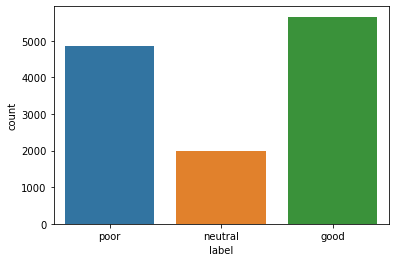

In [ ]:
# Let's view the count of each class

import seaborn as sns

sns.countplot(x=data['label'], data=data)

**Observations:**
- There are far fewer "neutral" instances than "poor" or "good", which is an indicator of the polarized nature of the text data seen in online user reviews - people generally rate something either very good or very poorly in their online behavior.

There are 1858712 words in the combination of all texts.


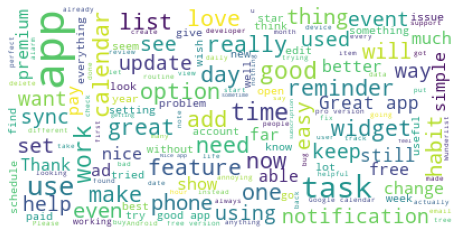

In [ ]:
# Let's look at the top 150 unique words in original feedback from the users

all_texts = " ".join(texts for texts in data.content)
print ("There are {} words in the combination of all texts.".format(len(all_texts)))

# Lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size = 40, max_words = 150, background_color="white").generate(all_texts)
plt.figure(figsize = (8,16))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**Observation:**
- There are 1,858,712 words present in the combination of overall text.

# **3. Data Preprocessing**

Let's now clean the data before going on to build the word embeddings for the text.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Jai Ganesh
[nltk_data]     Nagidi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Regex Expressions**

A regular expression matches a broad or specific text pattern, and is strictly read left-to-right.

- '^' is a symbol that extracts characters that starts with a given pattern.

**Let's apply the expression on a single data point, and see the results:**

In [ ]:
data['content'][0:10]

0                        I cannot open the app anymore
1    I have been begging for a refund from this app...
2    Very costly for the premium version (approx In...
3    Used to keep me organized, but all the 2020 UP...
4                                  Dan Birthday Oct 28
5    It has changed how I viewed my different lists...
6    I'm only looking for a grocery list app but ev...
7    Reset my free trial, new phone I'd like to see...
8    How do to stop monthly payment because i don't...
9    I complain about not crashes and it was immedi...
Name: content, dtype: object

In [ ]:
print("Before applying the expression :", data['content'][3])
pattern = '[^a-zA-Z0-9]'
res = re.sub(pattern, ' ', data['content'][3])

print("After applying the expression :", res)

Before applying the expression : Used to keep me organized, but all the 2020 UPDATES have made a mess of things !!! Y cudn't u leave well enuf alone ??? Guess ur techies feel the need to keep making changes to justify continuing to collect their salary !!! 🤤🤤🤤
After applying the expression : Used to keep me organized  but all the 2020 UPDATES have made a mess of things     Y cudn t u leave well enuf alone     Guess ur techies feel the need to keep making changes to justify continuing to collect their salary        


We can clearly observe that we have removed the special characters and numbers from the text. Also, we observe that there are extra spaces in many places in the text - let's remove these using another regular expression.

- **\s+**: The regular expression \s is a predefined character class. It indicates a single whitespace character. The plus sign + is a greedy quantifier, which means one or more times.

In [ ]:
print("Before applying the expression :", res)
pattern = '\s+'
resf = re.sub(pattern, ' ', res)

print("After applying the expression :", resf)

Before applying the expression : Used to keep me organized  but all the 2020 UPDATES have made a mess of things     Y cudn t u leave well enuf alone     Guess ur techies feel the need to keep making changes to justify continuing to collect their salary        
After applying the expression : Used to keep me organized but all the 2020 UPDATES have made a mess of things Y cudn t u leave well enuf alone Guess ur techies feel the need to keep making changes to justify continuing to collect their salary 


- We have successfully removed the extra spaces present in the text from the previous output.

Let's remove the numbers and other numerals from the data. The range [0-9] is not always equivalent to \d. In python3, [0-9] matches only 0123456789 characters, while \d matches [0-9] and other digit characters, for example Eastern Arabic numerals ٠١٢٣٤٥٦٧٨٩.

In [ ]:
print("Before applying the expression :", resf)
pattern = '\d+'
resl = re.sub(pattern, ' ', resf)

print("After applying the expression :", resl)

Before applying the expression : Used to keep me organized but all the 2020 UPDATES have made a mess of things Y cudn t u leave well enuf alone Guess ur techies feel the need to keep making changes to justify continuing to collect their salary 
After applying the expression : Used to keep me organized but all the   UPDATES have made a mess of things Y cudn t u leave well enuf alone Guess ur techies feel the need to keep making changes to justify continuing to collect their salary 


In [ ]:
final_corpus = []

for i in range(data.shape[0]):
    
    # It removes the numbers, special characters, spaces
    
    text = re.sub('[^a-zA-Z0-9]', ' ', data['content'][i])
    
    # Lowering the text
    text = text.lower()

    # To remove the extra spaces in the data
    text = re.sub(r'\s+',' ',text)

    # To remove the numbers and other arabic numeric symbols
    text = re.sub(r'\d',' ',text)

    # Splitting the text
    text = text.split()
    
    # Removing the stopwords
    text = [word for word in text if not word in stopwords.words('english')]
    
    # joining the words into text
    text = ' '.join(text)
    
    # appending the text to the final_corpus list
    final_corpus.append(text)
    
data['final_text'] = final_corpus

Let's look at the top 150 unique words in the feedback where we have applied some preprocessing steps:

There are 1155388 words in the combination of all texts.


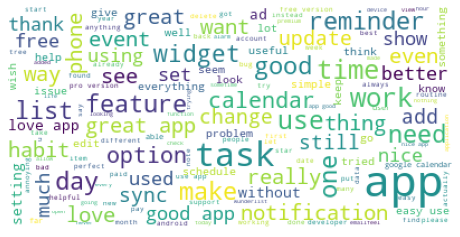

In [ ]:
all_texts1 = " ".join(texts for texts in data.final_text)
print ("There are {} words in the combination of all texts.".format(len(all_texts1)))

# Lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size = 40, max_words = 150, background_color="white").generate(all_texts1)
plt.figure(figsize = (8,16))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# **4. Word Embeddings**


Word Embeddings are a word representation type that represents words with a 1-Dimensional vector. The representations are such that **words with similar meanings or similar semantics will have similar vectors.** This is a Natural Language Understanding technique to map words into vectors of real numbers using various ML methods such as Neural Networks, probabilistic models, or dimensionality reduction on the word co-occurrence matrix. Some important word embedding models are Word2vec (Google), GloVe (Stanford), and FastText (Facebook).

In this notebook, we are going to look at the Word2vec and GloVe implementations of word embeddings.

## **4.1 Word2vec**

- **Word2vec is a group of shallow, two-layer neural networks** that are trained to represent the linguistic and contextual similarity of words through numbers based on their semantics as received from the corpus of text it is trained on. 
- Word2vec takes as its input a large corpus or document of text and produces a vector space. The choice for the dimensionality of the vector space /embedding vector is typically a few hundreds. Each unique word in the document is assigned a corresponding vector in the space. 
- Word vectors are positioned in the vector space such that words that share common contexts/meaning in the corpus are located close to one another in the space. **Mathematically, the embeddings of these words will have a dot product closer to 1.**
- Embeddings learned through Word2vec have proven to be successful on a variety of Natural Language Processing tasks.
- Word2vec retains the semantic meaning of different words in a document. The context information might be lost, which is why, **while using Word Embeddings in a Neural Network architecture, we use a Context vector along with the input and output vectors.** Another great advantage of the Word2vec approach is that the size of the embedding vector is small in comparison to the vocabulary size.


In [ ]:
words_list =[]

for i in data['final_text']:
    
    li = list(i.split(" "))
    
    words_list.append(li)

In [ ]:
# Let's have a look into words_list
words_list[0:5]

[['cannot', 'open', 'app', 'anymore'],
 ['begging', 'refund', 'app', 'month', 'nobody', 'replying'],
 ['costly',
  'premium',
  'version',
  'approx',
  'indian',
  'rupees',
  'per',
  'year',
  'better',
  'download',
  'premium',
  'version',
  'app',
  'apkmos',
  'website',
  'use',
  'microsoft',
  'list',
  'app',
  'far',
  'better'],
 ['used',
  'keep',
  'organized',
  'updates',
  'made',
  'mess',
  'things',
  'cudn',
  'u',
  'leave',
  'well',
  'enuf',
  'alone',
  'guess',
  'ur',
  'techies',
  'feel',
  'need',
  'keep',
  'making',
  'changes',
  'justify',
  'continuing',
  'collect',
  'salary'],
 ['dan', 'birthday', 'oct']]

### **4.1.1 Creating Word2vec word embeddings**

Word2vec takes the following three important parameters:

**Min_count**: It will ignore all the words with a total frequency lower than this.

**Workers**: These are the threads to train the model.

In [ ]:
!pip install --user gensim==3.8.3

In [ ]:
import gensim
print(gensim.__version__)

3.8.3


In [ ]:
# Model creation   
model= Word2Vec(words_list, min_count = 1, workers = 4)

In [ ]:
model

In [ ]:
# saving the model
model.save("word2vec.model")

Let's have a quick look at the vocabulary words:

In [ ]:
words = model.wv.vocab
len(words)

10766

**Observations:**
- Every word get mapped to an appropriate word index from the whole text present in the data.

**Let's check out a random word embedding using the trained model:**

In [ ]:
word = "problem"
model.wv[word]

array([ 0.5720429 , -0.53256977, -0.6883583 , -0.22681087,  0.5046703 ,
       -0.10360858, -0.13394511,  0.67490554,  0.0734144 ,  0.33032557,
       -0.4100157 ,  0.18264447,  0.20496336,  0.6051278 ,  0.10916104,
       -0.70018005, -0.47332314,  0.98642266,  0.70166785, -0.3348425 ,
       -0.7241002 , -0.23575215, -0.52972007, -0.19051425,  1.2167755 ,
       -0.18656226, -0.5252309 ,  0.2535656 , -0.18887454,  0.57281315,
        0.13118628,  0.4577378 ,  0.24768388,  0.76404154,  0.12702638,
        0.5882323 ,  0.16936919,  0.58445853, -1.1415573 , -0.68688047,
       -0.606867  ,  0.00975829, -0.94591624, -0.15768255,  0.39827794,
       -0.22520338, -0.54334897, -0.18011391, -0.90005434,  0.57086426,
       -0.8101381 , -0.19140904,  0.21927777,  0.02726179, -0.5629329 ,
       -0.47215095,  0.32070258, -0.22079207, -0.7081466 ,  0.39236274,
        0.27543053, -0.9134219 , -0.18041979,  0.04711047,  0.3527197 ,
       -0.2987285 ,  0.3047313 , -0.8117109 ,  0.26594064, -0.35

In [ ]:
# Let's see the vocab size
print("Length of the vocab is = ", len(list(model.wv.vocab)))

Length of the vocab is =  10766


In [ ]:
# Top 10 similar words to the word 'happy'

similar = model.wv.similar_by_word('happy')
print(similar)

[('enough', 0.9996694922447205), ('everything', 0.999653160572052), ('sucks', 0.9996442198753357), ('felt', 0.9996321201324463), ('downloaded', 0.9995812773704529), ('probably', 0.9995658993721008), ('bad', 0.9995384216308594), ('truly', 0.9995265603065491), ('paywall', 0.999494194984436), ('download', 0.9994838833808899)]


In [ ]:
# Top 10 similar words to the word 'premium'

similar = model.wv.similar_by_word('premium')
print(similar)

[('paid', 0.9986861348152161), ('free', 0.9890090823173523), ('buy', 0.9870593547821045), ('bought', 0.984952449798584), ('full', 0.9815046787261963), ('pro', 0.980965793132782), ('pay', 0.9799292683601379), ('payed', 0.9793205261230469), ('upgraded', 0.9747048616409302), ('restricted', 0.9720046520233154)]


### **4.1.2 Building the classifier**

In [ ]:
words = model.wv.vocab
wvs = model.wv[words]

In [ ]:
from gensim.models import Word2Vec

In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    
    vocabulary = set(model.wv.vocab)
    
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    
    return np.array(features)




feature_size = 100

# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus = words_list, model = model,
                                             num_features = feature_size)
pd.DataFrame(w2v_feature_array)

<ipython-input-47-05b927baf5e8>:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  feature_vector = np.add(feature_vector, model[word])


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.536190,-0.519537,-0.658590,-0.157023,0.457673,-0.043798,-0.121651,0.582177,0.115517,0.268305,...,-0.419167,0.238583,0.038800,0.093945,0.814860,0.433681,0.278603,0.148597,-0.112035,-0.093149
1,0.253173,-0.253027,-0.312674,-0.063495,0.223050,-0.019351,-0.070325,0.265639,0.058857,0.114277,...,-0.193175,0.121744,0.008144,0.067948,0.388844,0.203634,0.146861,0.086564,-0.051732,-0.049159
2,0.353417,-0.418336,-0.548184,-0.076443,0.456038,-0.064713,-0.181417,0.438536,0.082809,0.177365,...,-0.279991,0.085989,0.074570,0.201465,0.663614,0.261555,0.220960,0.242445,-0.134292,-0.041607
3,0.349426,-0.335396,-0.429521,-0.098940,0.295718,-0.024861,-0.051540,0.360143,0.094649,0.172369,...,-0.240476,0.156642,0.014259,0.055077,0.481153,0.265567,0.175478,0.077135,-0.079736,-0.046121
4,0.092336,-0.086426,-0.108143,-0.033770,0.077160,-0.012548,-0.013484,0.103447,0.015064,0.054510,...,-0.071052,0.033141,0.001553,0.003212,0.135038,0.083506,0.040614,0.007976,-0.023897,-0.013932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12490,0.374667,-0.347210,-0.446975,-0.110612,0.283831,-0.013730,-0.024983,0.364465,0.112108,0.175100,...,-0.232393,0.178285,0.012444,0.023818,0.451073,0.278236,0.175314,0.064099,-0.068225,-0.051713
12491,0.004176,0.001939,0.000716,0.002458,-0.002675,-0.004550,-0.004539,-0.001381,0.001005,0.000202,...,-0.000984,0.004663,-0.003052,-0.001947,-0.004375,0.002066,-0.003211,-0.003614,0.004914,0.002312
12492,0.565997,-0.527746,-0.706395,-0.160247,0.516465,-0.051103,-0.114815,0.606972,0.140570,0.283965,...,-0.379805,0.236241,0.033420,0.108723,0.809208,0.418149,0.274395,0.156234,-0.119611,-0.072992
12493,0.490264,-0.475827,-0.618242,-0.163003,0.431366,-0.039940,-0.108437,0.547316,0.112436,0.253190,...,-0.362470,0.190677,0.052702,0.064903,0.690827,0.395771,0.206264,0.131406,-0.120925,-0.059243


In [ ]:
y

array([2, 2, 2, ..., 0, 0, 0])

In [ ]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(w2v_feature_array,y, test_size=0.2, random_state=42)

In [ ]:
# intializing the Random Forest model
model = RandomForestClassifier(random_state = 7)

# fitting the model on training set
model.fit(xtrain,ytrain)

RandomForestClassifier(random_state=7)

In [ ]:
# making predictions on the test set
y_pred = model.predict(xtest)

# checking the metrics
print(classification_report(y_pred, ytest))

              precision    recall  f1-score   support

           0       0.76      0.68      0.72      1261
           1       0.03      0.21      0.05        57
           2       0.73      0.60      0.66      1181

    accuracy                           0.63      2499
   macro avg       0.51      0.50      0.48      2499
weighted avg       0.73      0.63      0.68      2499



## **4.2 GloVe Vectors**

**Global Vectors for Word Representation, also known as GloVe**, is an alternative to Word2vec. Just like Word2vec, it is also an unsupervised learning algorithm that allows us to take a corpus of text, and intuitively map each word in that document into a position in a high-dimensional latent space which gives us the vector representation of the word.

### **4.2.1 Creating GloVe Vectors**

In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open(r'glove.6B\glove.6B.300d.txt', encoding="utf8")

for line in tqdm(f):
    # Splitting the each line 
    values = line.split()
    
    word = values[0]
    
    coefs = np.array(values[1:], dtype='float32')
    
    embeddings_index[word] = coefs
    
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:29, 13493.08it/s]

Found 400000 word vectors.


In [ ]:
# This function creates a normalized vector for the whole sentence

def sent2vec(s):
    words = word_tokenize(s)
    N = []
    for w in words:
        try:
            N.append(embeddings_index[w])
        except:
            continue
    N = np.array(N)
    v = N.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [ ]:
# Let's have a quick look on the independent feature
data.final_text.values

array(['cannot open app anymore',
       'begging refund app month nobody replying',
       'costly premium version approx indian rupees per year better download premium version app apkmos website use microsoft list app far better',
       ..., 'useful apps must try',
       'would pay even additions updates absolutely love wish would develop even',
       'sooow good'], dtype=object)

In [ ]:
y = ln.fit_transform(data['label'])
y

array([2, 2, 2, ..., 0, 0, 0])

In [ ]:
xtrain, xvalid, ytrain, yvalid = train_test_split(data.final_text.values, y, 
                                                  stratify = y, 
                                                  random_state = 42, 
                                                  test_size = 0.2, shuffle = True)

In [ ]:
print("Shape of Training set : ", xtrain.shape)

print("Shape of test set : ", xvalid.shape)

print("Percentage of classes in training set:")

print(ytrain.value_counts(normalize = True))

print("Percentage of classes in test set:")

print(yvalid.value_counts(normalize = True))

In [ ]:
# Create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

100%|████████████████████████████████████████████████████████████████████████████| 2499/2499 [00:00<00:00, 7502.06it/s]


### **4.2.2 Building the classifier**

In [ ]:
# intializing the Random Forest model
model = RandomForestClassifier(random_state = 7)

# fitting the model on training set
model.fit(xtrain_glove,ytrain)

RandomForestClassifier(random_state=7)

In [ ]:
# making predictions on the test set
y_pred = model.predict(xvalid_glove)

# checking the metrics
print(classification_report(y_pred,yvalid))

              precision    recall  f1-score   support

           0       0.81      0.73      0.76      1257
           1       0.01      0.44      0.02         9
           2       0.80      0.63      0.70      1233

    accuracy                           0.68      2499
   macro avg       0.54      0.60      0.50      2499
weighted avg       0.80      0.68      0.73      2499



# **5. Conclusions and Business Recommendations**

**Conclusions**

- Both the models differ in the way they are trained, and hence they output different word vectors.

- The GloVe model is based on global word-to-word co-occurrence counts taking the whole corpus into consideration, whereas Word2vec uses co-occurrence of local context (neighboring words).

- GloVe learns its embeddings by constructing the overall co-occurrence matrix, on the other hand, the Word2vec model learns by making predictions by taking context words as inputs and predicting the target words.

- Represent words as semantically-meaningful dense real-valued vectors.

- This overcomes many of the problems that simple one-hot vector encodings have.

- Most importantly, embeddings boost generalisation and performance for pretty much any NLP problem, especially if you don’t have a lot of training data.

**Business Recommendations**

- **Dense embedding models such as Word2vec and GloVe can be very useful in automatic sentiment analysis** of the reviews of an app on the Google Play Store, and tracking its progression through time.

- Outside of sentiment analysis and classification oriented tasks, Unsupervised Learning can also be performed to group the reviews into various clusters, which would likely represent certain themes due to the semantic nature of the word embeddings generated by Word2vec and GloVe. This could be another use case of using dense embeddings to extract insights from the text.